# **Clusterização (Agrupamento)**

Objetivo: médodo de aprendizagem não-supervisionada onde se busca encontrar padrões em dados brutos, de forma a obter grupos (*clusters*) com características distintas.

> **Funcionamento:**

<img src="https://github.com/OviedoVR/ML_especializacao/blob/main/assets/kmeans-working.png?raw=true" width="450px"/>

<br>

> **Tipos de clusterização:**

<img src="https://github.com/OviedoVR/ML_especializacao/blob/main/assets/clustering-types.png?raw=true" width="90%"/>

[10.1016/j.psychres.2023.115265](https://doi.org/10.1016/j.psychres.2023.115265)

Artigo: [data-clustering-python](https://builtin.com/data-science/data-clustering-python)


In [1]:
%%writefile custom_layout.py
import plotly.express as px

# Define a custom layout dictionary
custom_layout = {
    'width': 700,
    'height': 400,
    'paper_bgcolor': 'white',
    'plot_bgcolor': 'white',
    'font': {'family': 'Palatino', 'size': 12},
    'xaxis_showgrid': False,
    'yaxis_showgrid': False,
    'xaxis_linecolor': 'lightgray',
    'yaxis_linecolor': 'lightgray',
    'xaxis_zeroline': False,
    'xaxis': {'showline': True}
}

# Set the default template:
px.defaults.template = 'simple_white'

# Defining a color palette:
color_discrete_sequence = ['#bdbf09', '#2292a4', 'lightgray', '#CE4760', '#d96c06']

# Create a custom marker style dictionary
custom_marker_style = {
    'size': 10,            # Adjust the size as needed
    'line_width': 1,
    'opacity': 0.7         # Adjust the opacity as needed
}

Overwriting custom_layout.py


In [2]:
# -- Manipulação de dados:
import numpy as np
import pandas as pd

# -- Desligar warnings:
import warnings

# -- Visualização de dados:
import plotly.express as px                              # core library
import plotly.graph_objs as go                           # core library
from plotly.subplots import make_subplots                # core library
import matplotlib.pyplot as plt                          # auxiliar
import seaborn as sns                                    # auxiliar
from custom_layout import *

# -- Modelagem:
from sklearn.pipeline import Pipeline                    # pipelines
from sklearn.preprocessing import StandardScaler         # normalização
from sklearn.preprocessing import LabelEncoder           # codificação dados categóricos
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans                       # agrupamento
from sklearn.metrics import silhouette_score             # validação

## Pipeline

O pipeline segue os passos a seguir:

1. Criar o dataset da *features*
2. Criar uma amostra do dataset, em caso de datasets grandes (OPCIONAL)
3. Modelagem: agrupamento com K-Means
4. Realizar novas predições (OPCIONAL)
5. Exploração interativa dos clusters

Para cada etapa, temos funções a serem aplicadas.

**Funções**

In [3]:
def copy_dataframe(dataframe):
    #Creates a copy of the input dataframe (backup)

    copied_df = dataframe.copy()
    return copied_df
# --------------------------------------------------------------------- Normalização:
def scale_features(dataframe, selected_columns):
    """
    Normalizes the selected numercial columns of  a dataframe
    """
    features = dataframe[selected_columns]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_df = pd.DataFrame(scaled_features, columns=selected_columns)

    return scaled_df
# ----------------------------------------------------------------------- Codificação:
def label_encode_features(dataframe, selected_columns):
    """
    Encodes the selected categorical columns of a dataframe
    """
    encoded_df = dataframe.copy()

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Apply the LabelEncoder to the selected columns
    for column in selected_columns:
        if column in encoded_df.columns:
            encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

    return encoded_df
# --------------------------------------------------------------------------------- Escolha do k:
def elbow_silhouette_subplots(dataframe, max_clusters, template='simple_white'):
    """
    Generate elbow and silhouette score subplots for different numbers of clusters.
    Args:
      - dataframe (pd.DataFrame): The DataFrame containing the features.
      - max_clusters (int): The maximum number of clusters to consider.
      - template (str): Plotly template for the plots (default is 'simple_white').
    Returns:
      - None (displays the subplots).
    """
    # Suppress FutureWarnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Create empty lists to store inertia (within-cluster sum of squares) and silhouette scores
    inertias = []
    silhouette_scores = []

    # Iterate through different numbers of clusters and fit K-Means
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=35)
        cluster_labels = kmeans.fit_predict(dataframe)

        # Calculate the inertia and silhouette score
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(dataframe, cluster_labels))

    # Convert the range to a list
    num_clusters = list(range(2, max_clusters + 1))

    # Create subplots with two columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Elbow Method', 'Silhouette Score'])

    # Add the elbow plot to the first subplot
    fig.add_trace(go.Scatter(x=num_clusters, y=inertias, mode='lines+markers', name='Inertia'), row=1, col=1)
    fig.update_xaxes(title_text='Number of Clusters', row=1, col=1)
    fig.update_yaxes(title_text='Inertia', row=1, col=1)

    # Add the silhouette score plot to the second subplot
    fig.add_trace(go.Scatter(x=num_clusters, y=silhouette_scores, mode='lines+markers', name='Silhouette Score'), row=1, col=2)
    fig.update_xaxes(title_text='Number of Clusters', row=1, col=2)
    fig.update_yaxes(title_text='Silhouette Score', row=1, col=2)

    # Update the layout
    fig.update_layout(title='Elbow Method and Silhouette Score', template=template)
    fig.show()
# --------------------------------------------------------------------------------- K-means:
def apply_kmeans(dataframe, k):
    """
    Apply K-Means clustering to the input dataframe.
    Args:
      - dataframe (pd.DataFrame): The DataFrame containing the features.
      - k (int): The number of clusters to create.
    Returns:
      - labels (pd.Series): A Series containing cluster labels for each row.
    """
    kmeans = KMeans(n_clusters=k, random_state=35)
    labels = kmeans.fit_predict(dataframe)

    return labels

## **Modelagem**

### ***Dados***

In [4]:
!wget -q 'https://raw.githubusercontent.com/OviedoVR/ML_especializacao/main/dados/campaings.csv' -O 'campaings.csv'

**Dicionário de dados**

| Field             | Description                                               |
|-------------------|-----------------------------------------------------------|
| ID                | Customer's unique identifier                              |
| Education         | Customer's education level                                |
| Age               | Customer's age                                            |
| Marital_Status    | Customer's marital status                                 |
| Kidhome           | Number of children in customer's household                |
| Teenhome          | Number of teenagers in customer's household               |
| Country           | Customer's country                                        |
| Recency           | Number of days since customer's last purchase             |
| Purchases         | Number of purchases made                                  |
| Spent_percent     | Spent % (of overall)                                      |
| Income            | Customer's yearly household income                        |
| CampaingsAccepted | Number of accepted campaings                              |
| Complain          | 1 if customer complained in the last 2 years, 0 otherwise |
| Spent             | How much the customer spent                               |

In [5]:
customers = pd.read_csv('campaings.csv')
customers.head()

,ID,Education,Age,DaysAsCustomer,Marital_Status,Kidhome,Teenhome,Country,Recency,Purchases,Spent_percent,Income,CampaingsAccepted,Complain,Spent
0,1826,Graduation,53,3392,Divorced,0,0,Spain,0,15,0.088457,84835.0,0,0,1190
1,1,Graduation,62,3393,Single,0,0,Canada,0,18,0.042891,57091.0,1,0,577
2,10476,Graduation,65,3426,Married,0,1,USA,0,11,0.018658,67267.0,0,0,251
3,1386,Graduation,56,3428,Together,1,1,Australia,0,4,0.000818,32474.0,0,0,11
4,5371,Graduation,34,3461,Single,1,0,Spain,0,8,0.006764,21474.0,1,0,91


In [6]:
customers.shape

(2216, 15)

In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2216 non-null   int64  
 1   Education          2216 non-null   object 
 2   Age                2216 non-null   int64  
 3   DaysAsCustomer     2216 non-null   int64  
 4   Marital_Status     2216 non-null   object 
 5   Kidhome            2216 non-null   int64  
 6   Teenhome           2216 non-null   int64  
 7   Country            2216 non-null   object 
 8   Recency            2216 non-null   int64  
 9   Purchases          2216 non-null   int64  
 10  Spent_percent      2216 non-null   float64
 11   Income            2216 non-null   float64
 12  CampaingsAccepted  2216 non-null   int64  
 13  Complain           2216 non-null   int64  
 14  Spent              2216 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 259.8+ KB


In [8]:
customers.isna().sum() / len(customers) * 100

ID                   0.0
Education            0.0
Age                  0.0
DaysAsCustomer       0.0
Marital_Status       0.0
Kidhome              0.0
Teenhome             0.0
Country              0.0
Recency              0.0
Purchases            0.0
Spent_percent        0.0
 Income              0.0
CampaingsAccepted    0.0
Complain             0.0
Spent                0.0
dtype: float64

In [9]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2216.0,5588.353339,3249.376275,0.000000,2814.750000,5458.500000,8421.750000,11191.000000
Age,2216.0,54.179603,11.985554,27.000000,46.000000,53.000000,64.000000,130.000000
DaysAsCustomer,2216.0,3732.521209,202.434667,3379.000000,3559.000000,3734.500000,3908.000000,4078.000000
Kidhome,2216.0,0.441787,0.536896,0.000000,0.000000,0.000000,1.000000,2.000000
Teenhome,2216.0,0.505415,0.544181,0.000000,0.000000,0.000000,1.000000,2.000000
Recency,2216.0,49.012635,28.948352,0.000000,24.000000,49.000000,74.000000,99.000000
Purchases,2216.0,14.880866,7.670957,0.000000,8.000000,15.000000,21.000000,44.000000
Spent_percent,2216.0,0.045126,0.044816,0.000372,0.005129,0.029473,0.077902,0.187693
Income,2216.0,52247.251354,25173.076661,1730.000000,35303.000000,51381.500000,68522.000000,666666.000000
CampaingsAccepted,2216.0,0.298285,0.679209,0.000000,0.000000,0.000000,0.000000,4.000000


In [10]:
customers.query('Age <= 90')

,ID,Education,Age,DaysAsCustomer,Marital_Status,Kidhome,Teenhome,Country,Recency,Purchases,Spent_percent,Income,CampaingsAccepted,Complain,Spent
0,1826,Graduation,53,3392,Divorced,0,0,Spain,0,15,0.088457,84835.0,0,0,1190
1,1,Graduation,62,3393,Single,0,0,Canada,0,18,0.042891,57091.0,1,0,577
2,10476,Graduation,65,3426,Married,0,1,USA,0,11,0.018658,67267.0,0,0,251
3,1386,Graduation,56,3428,Together,1,1,Australia,0,4,0.000818,32474.0,0,0,11
4,5371,Graduation,34,3461,Single,1,0,Spain,0,8,0.006764,21474.0,1,0,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,10142,PhD,47,3858,Divorced,0,1,USA,99,20,0.051216,66476.0,0,0,689
2212,5263,2n Cycle,46,3902,Married,1,0,Spain,99,5,0.004088,31056.0,0,0,55
2213,22,Graduation,47,3952,Divorced,1,0,Spain,99,14,0.022969,46310.0,0,0,309
2214,528,Graduation,45,3956,Married,0,0,India,99,20,0.102804,65819.0,0,0,1383


### **Features**

In [11]:
# Backup and features
customers = copy_dataframe(customers)
features = customers.copy()
features.drop(['ID', 'Country'], axis=1, inplace=True)

# Scale the selected columns and update 'features'
scaled_columns = [
    'Age', 'DaysAsCustomer', 'Kidhome', 'Teenhome',
    'Recency', 'Purchases', 'Spent_percent',
    ' Income ', 'CampaingsAccepted', 'Complain'
]
scaled_features = scale_features(features, scaled_columns)
features[scaled_columns] = scaled_features

# Encode the selected columns and update 'features'
encoded_columns = ['Education', 'Marital_Status']
encoded_features = label_encode_features(features, encoded_columns)
features[encoded_columns] = encoded_features[encoded_columns]

# 'features' now contains both scaled and encoded data
features.head(4)

,Education,Age,DaysAsCustomer,Marital_Status,Kidhome,Teenhome,Recency,Purchases,Spent_percent,Income,CampaingsAccepted,Complain,Spent
0,2,-0.098441,-1.682509,2,-0.823039,-0.928972,-1.693488,0.015534,0.967085,1.294840,-0.439265,-0.097812,1190
1,2,0.652633,-1.677568,4,-0.823039,-0.928972,-1.693488,0.406708,-0.049896,0.192461,1.033369,-0.097812,577
2,2,0.902990,-1.514515,3,-0.823039,0.909066,-1.693488,-0.506031,-0.590737,0.596794,-0.439265,-0.097812,251
3,2,0.151917,-1.504633,5,1.039938,0.909066,-1.693488,-1.418770,-0.988903,-0.785669,-0.439265,-0.097812,11


In [12]:
features.shape

(2216, 13)

In [13]:
customers.shape

(2216, 15)

### **Escolha do K**

In [14]:
# Selection on 'k'
elbow_silhouette_subplots(features[['Spent_percent', 'Age']], max_clusters=10)

Exmplo do Elbow:

Esse método usa o WCSS. Do inglês *within cluster sum of squares* ou soma dos quadrados dentro do cluster, o WCSS mede o quão próximo o centróide $x_c$ de um cluster está dos objectos alocados. O resultado pode ser interpretado com uma medida de proximidade dos objetos agrupados pois se o WCSS é baixo, os objetos estão próximos do centróide e, por consequência, próximos entre si. Matematicamente, é dado por:

\begin{equation}
  WCSS(x^k,x_c^k) = \sum_{i=1}^{n} (x_i^k-x_c^k)^{2}
\end{equation}

> No Python:

```python
# lista vazia
WCSS = []

# loop de iteração (teste com n clusters)
for k in range(1, 11):
  modelo_clustering = KMeans(n_clusters=k, random_state = 42)
  modelo_clustering = modelo_clustering.fit(dados)   # retorna os clusters
  WCSS.append(modelo_clustering.inertia_)             # armazena o WCSS na lista vazia

# visualização
with sns.axes_style('darkgrid'):
  grafico_ellbow = sns.lineplot(x=range(1, 11), y=WCSS, marker="8", color='k');
  grafico_ellbow.set(title='Método do Cotovelo', ylabel='WCSS', xlabel='Número de clusters');
```

### **Clusterização**

In [15]:
# Applying clustering
cluster_labels = apply_kmeans(features, k=4)
features['cluster'] = cluster_labels.astype(str)
customers['cluster'] = cluster_labels.astype(str)

### **Exploração dos clusters**

In [16]:
customers.columns

Index(['ID', 'Education', 'Age', 'DaysAsCustomer', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Country', 'Recency', 'Purchases', 'Spent_percent',
       ' Income ', 'CampaingsAccepted', 'Complain', 'Spent', 'cluster'],
      dtype='object')

In [17]:
fig = px.scatter(
    customers,
    x = 'Spent',
    y = ' Income ',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Gasots x Renda anual',
    width=700,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [18]:
fig = px.box(
    customers,
    y = 'Spent',
    facet_col = 'Kidhome',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Gastos x Crianças em casa',
    width=700,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [19]:
fig = px.strip(
    customers.query('Marital_Status in ["Single", "Married", "Divorced"]'),
    y = 'Spent',
    facet_col = 'Marital_Status',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Gastos x Crianças em casa',
    width=1000,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [20]:
fig = px.strip(
    customers,
    y = 'Spent',
    facet_col = 'Teenhome',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Gastos x Crianças em casa',
    width=1000,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [21]:
fig = px.box(
    customers,
    y = 'Spent',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Qual cluster gasta mais',
    width=700,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [22]:
fig = px.strip(
    customers,
    y = 'Recency',
    facet_col='Kidhome',
    color = 'cluster',
    color_discrete_sequence = color_discrete_sequence
)

fig.update_traces(marker=custom_marker_style)

fig.update_layout(
    title='Recência por cluster e filhos pequenos em casa',
    width=700,
    height=400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    title_x=0.45,
    legend_title='Cluster',
)
fig.show()

In [23]:
# Selecionar apenas as colunas numéricas e a coluna 'cluster'
clustered_customers = customers.copy()
encoded_columns = ['Education', 'Marital_Status']
clustered_customers = label_encode_features(clustered_customers, encoded_columns)
clustered_customers[encoded_columns] = clustered_customers[encoded_columns]
clustered_customers.drop(['Country', 'ID'], axis=1, inplace=True)
clustered_customers.groupby('cluster').median().style.background_gradient()

,Education,Age,DaysAsCustomer,Marital_Status,Kidhome,Teenhome,Recency,Purchases,Spent_percent,Income,CampaingsAccepted,Complain,Spent
cluster,,,,,,,,,,,,,
0,2.000000,53.000000,3812.500000,4.000000,0.000000,0.000000,53.000000,22.000000,0.125662,78664.500000,1.000000,0.000000,1690.500000
1,2.000000,51.000000,3690.000000,4.000000,1.000000,0.000000,49.000000,7.000000,0.004906,34951.000000,0.000000,0.000000,66.000000
2,2.000000,58.000000,3792.000000,3.000000,0.000000,0.000000,52.000000,22.000000,0.081916,69508.000000,0.000000,0.000000,1102.000000
3,2.000000,55.000000,3749.000000,4.000000,0.000000,1.000000,46.000000,20.000000,0.041701,56559.000000,0.000000,0.000000,561.000000


In [24]:
clustered_customers_summary =clustered_customers.groupby('cluster', as_index=False).median()
clustered_customers_summary['Ticket'] = clustered_customers_summary['Spent']/clustered_customers_summary['Purchases']
clustered_customers_summary[['cluster', 'Ticket']].style.bar(subset='Ticket', color='chartreuse')

,cluster,Ticket
0,0,76.840909
1,1,9.428571
2,2,50.090909
3,3,28.050000


In [25]:
clustered_customers.groupby('cluster').mean().style.background_gradient()

,Education,Age,DaysAsCustomer,Marital_Status,Kidhome,Teenhome,Recency,Purchases,Spent_percent,Income,CampaingsAccepted,Complain,Spent
cluster,,,,,,,,,,,,,
0,2.620567,54.226950,3783.918440,3.797872,0.060284,0.205674,51.209220,21.578014,0.130459,78957.446809,1.060284,0.000000,1755.031915
1,2.284906,52.238679,3700.902830,3.711321,0.765094,0.486792,48.993396,8.127358,0.007468,36230.892453,0.084906,0.011321,100.464151
2,2.439024,57.135255,3761.543237,3.682927,0.064302,0.507761,49.401330,22.082040,0.082687,69496.252772,0.388027,0.008869,1112.374723
3,2.468085,55.860520,3746.546099,3.761229,0.288416,0.749409,47.182033,19.661939,0.042560,56185.231678,0.229314,0.011820,572.546099


In [26]:
customers_by_clusters = customers.groupby('cluster', as_index=False)['ID'].count()
customers_by_clusters = customers_by_clusters.rename(columns={'ID': 'Customers'})
customers_by_clusters = customers_by_clusters.sort_values('Customers')
customers_by_clusters

,cluster,Customers
0,0,282
3,3,423
2,2,451
1,1,1060


**Dendograma (Clusterização Hierárquica)**

- Clusterização Hierárquica Algomerativa (bottom-up)
- Clusterização Hierárquica Divisiva (top-down)
- Métodos para o cálculo da distância.

<img src="https://github.com/OviedoVR/ML_especializacao/blob/main/assets/HC-linkages.png?raw=true" width="600px"/>

DOI: [10.1016/j.crfs.2023.100522](https://doi.org/10.1016/j.crfs.2023.100522)

Material complementar: [Hierarchical Clustering](https://www.learndatasci.com/glossary/hierarchical-clustering/)


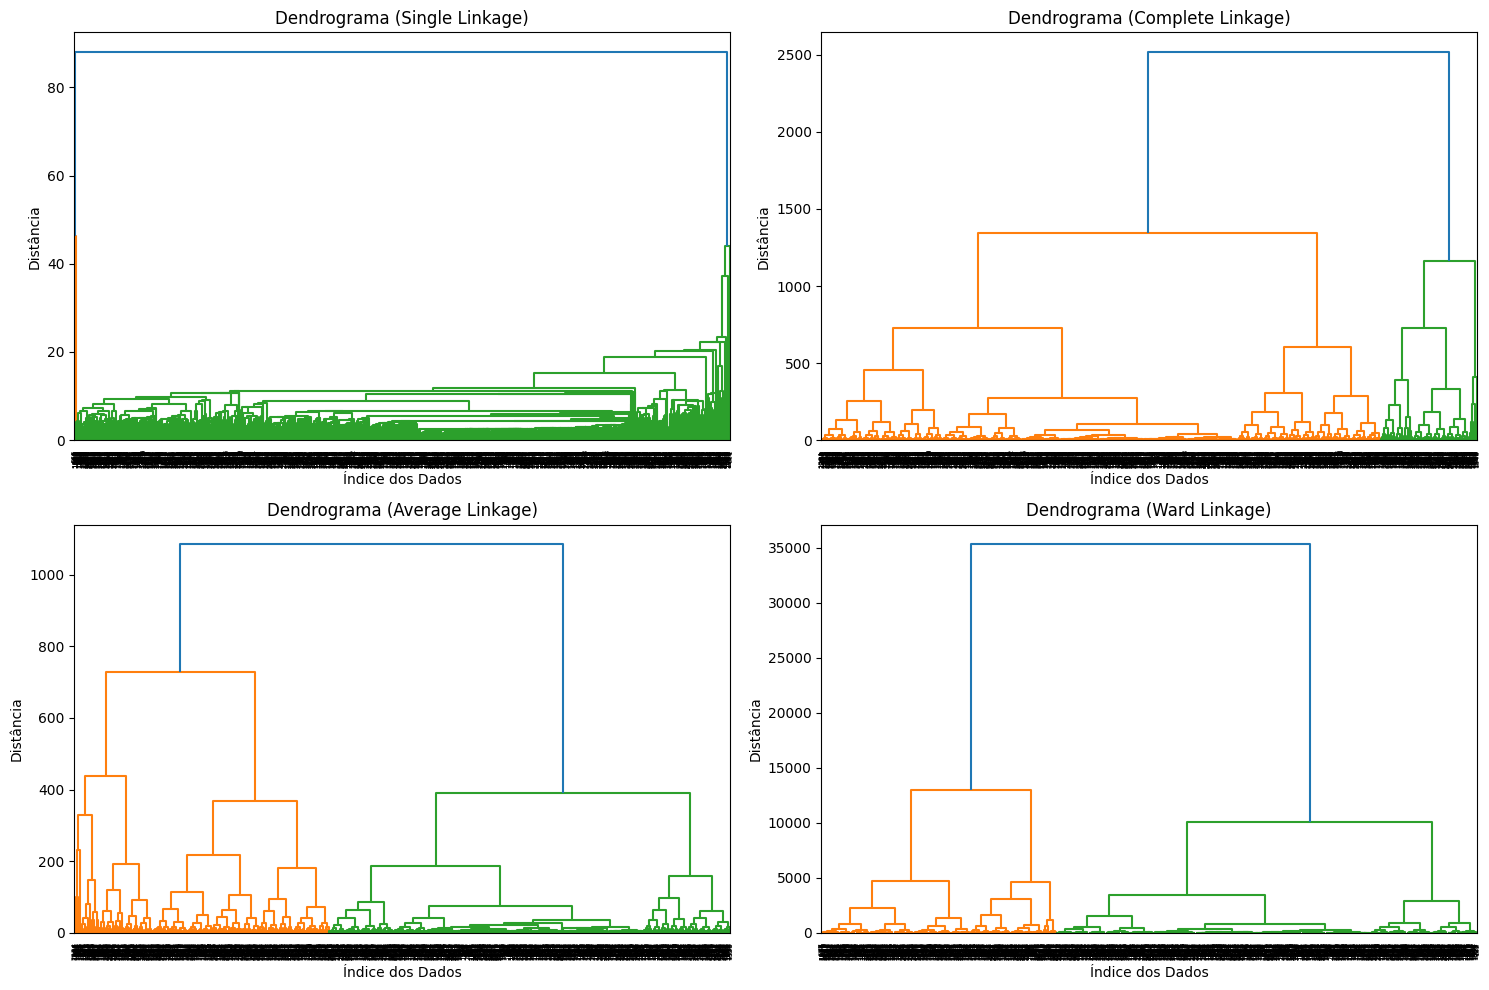

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

methods = ['single', 'complete', 'average', 'ward']
data = features

plt.figure(figsize=(15, 10))

for i, method in enumerate(methods):
    plt.subplot(2, 2, i+1)
    linked = linkage(data, method=method)
    dendrogram(linked, orientation='top', labels=range(len(data)), distance_sort='descending', show_leaf_counts=True)
    plt.title(f'Dendrograma ({method.capitalize()} Linkage)')
    plt.xlabel('Índice dos Dados')
    plt.ylabel('Distância')

plt.tight_layout()
plt.show()

### **Para os stakeholders**

Personas:

**Cluster 0:**
- Em torno de 54 anos
- Solteiro
- Sem filhos
- Grupo que mais gasta (média em torno de USD 1690)
- Aceita as campanhas enviadas
- Interessante para testes A/B
- Experimentação para estratégias de pricing

**Cluster 1:**
- Em torno de 52 anos
- Filhos em casa (pequenos)
- Recência e 49 dias e poucas compras (menor entre os grupos)
- Gastam menos (público menos rentável - 66 USD)
- Menor renda entre os grupos
- Oferecer produtos de baixo ticket pode ser interessante (vender em escala).


**Cluster 2:**
- 57 Anos
- Não tem filhos
- Segundo maior Ticket  (1102 USD)
- Não costuma aceitar campanhas
- Renda média-alta
- Oferecer promoções ou cashback pode ser interessante
- Não enviar muitos e-mails (estratégia de marketing para esse público)
- Buscar diminuir o valor da recência

**Cluster 3:**
- 56 anos
- Solteiro
- Filhos jovens em casa
- Menor Recência
- Compra relativamente com frequência similar aos clusters 0 e 2
- Gasta em torno de 561 USD
- Ticket de 28 USD
- Também não responde campanhas de marketing
- Aqui é interessante fidelizar bem este público, com programa de pontos, cashback, promoções com o valor beirando ao ticket, entender aonde esse público gasta
- Experimentação para estratégias de pricing
